In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torchvision import datasets, transforms

# Custom dataset class to add noise
class NoisyFashionMNIST(datasets.FashionMNIST):
    def __init__(self, *args, noise_factor=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.noise_factor = noise_factor

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        # Add noise to the image
        noise = torch.randn_like(img) * self.noise_factor
        noisy_img = img + noise
        # Clip the values to be in the range [0, 1]
        noisy_img = torch.clamp(noisy_img, 0, 1)
        return noisy_img, target

e
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = NoisyFashionMNIST('F_MNIST_data', download=True, train=True, transform=transform, noise_factor=0.1)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)


100%|██████████| 26421880/26421880 [00:02<00:00, 12258392.53it/s]


Extracting F_MNIST_data/NoisyFashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/NoisyFashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 250364.81it/s]


Extracting F_MNIST_data/NoisyFashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/NoisyFashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4309911.64it/s]


Extracting F_MNIST_data/NoisyFashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/NoisyFashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12837263.37it/s]


Extracting F_MNIST_data/NoisyFashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/NoisyFashionMNIST/raw



100%|██████████| 26421880/26421880 [00:02<00:00, 12851569.49it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 230119.12it/s]


Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4280262.50it/s]


Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19024032.59it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw



In [2]:

train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [3]:

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 28, 28]) torch.Size([64])
Pullover


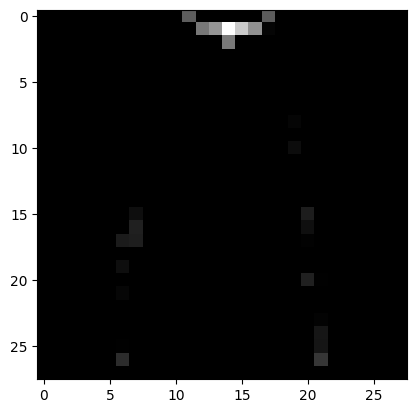

In [4]:
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

## Build the network

In [5]:
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)


    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device

In [6]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


## Train the network

In [7]:
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)
            outputs = model(images)
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            train_epoch_loss = train_epoch_loss/len(trainloader)

            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    images = images.view(images.shape[0], -1)
                    test_outputs = model(images)
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.7096465893189112251, val_loss: 0.5562490820884704590,  val_acc: 79.85%
Epoch: 1 -> train_loss: 0.5530984996954599886, val_loss: 0.4990225434303283691,  val_acc: 81.96%
Epoch: 2 -> train_loss: 0.5008824172417323251, val_loss: 0.4796326458454132080,  val_acc: 82.20%
Epoch: 3 -> train_loss: 0.4723630568981170841, val_loss: 0.4688727259635925293,  val_acc: 82.97%
Epoch: 4 -> train_loss: 0.4451500327785810063, val_loss: 0.4686064720153808594,  val_acc: 82.92%
Epoch: 5 -> train_loss: 0.4307135126988093088, val_loss: 0.4925282299518585205,  val_acc: 82.35%
Epoch: 6 -> train_loss: 0.4146857320070266861, val_loss: 0.4468675553798675537,  val_acc: 83.69%
Epoch: 7 -> train_loss: 0.3989597778320312371, val_loss: 0.4461985230445861816,  val_acc: 84.11%
Epoch: 8 -> train_loss: 0.3889933727184931578, val_loss: 0.4556511938571929932,  val_acc: 83.73%
Epoch: 9 -> train_loss: 0.3769615363677342734, val_loss: 0.4502561092376708984,  val_acc: 83.74%
Epoch: 10 -> train_loss: 0.368

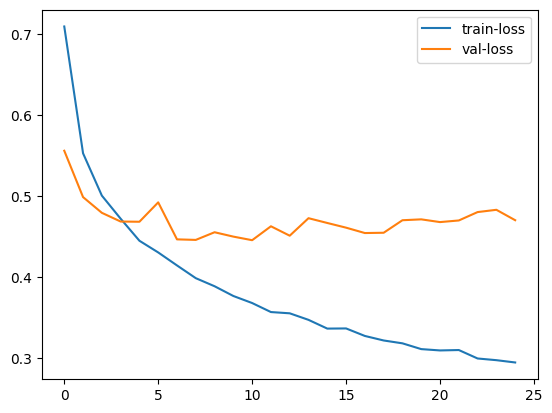

In [8]:
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

### Predict a single image

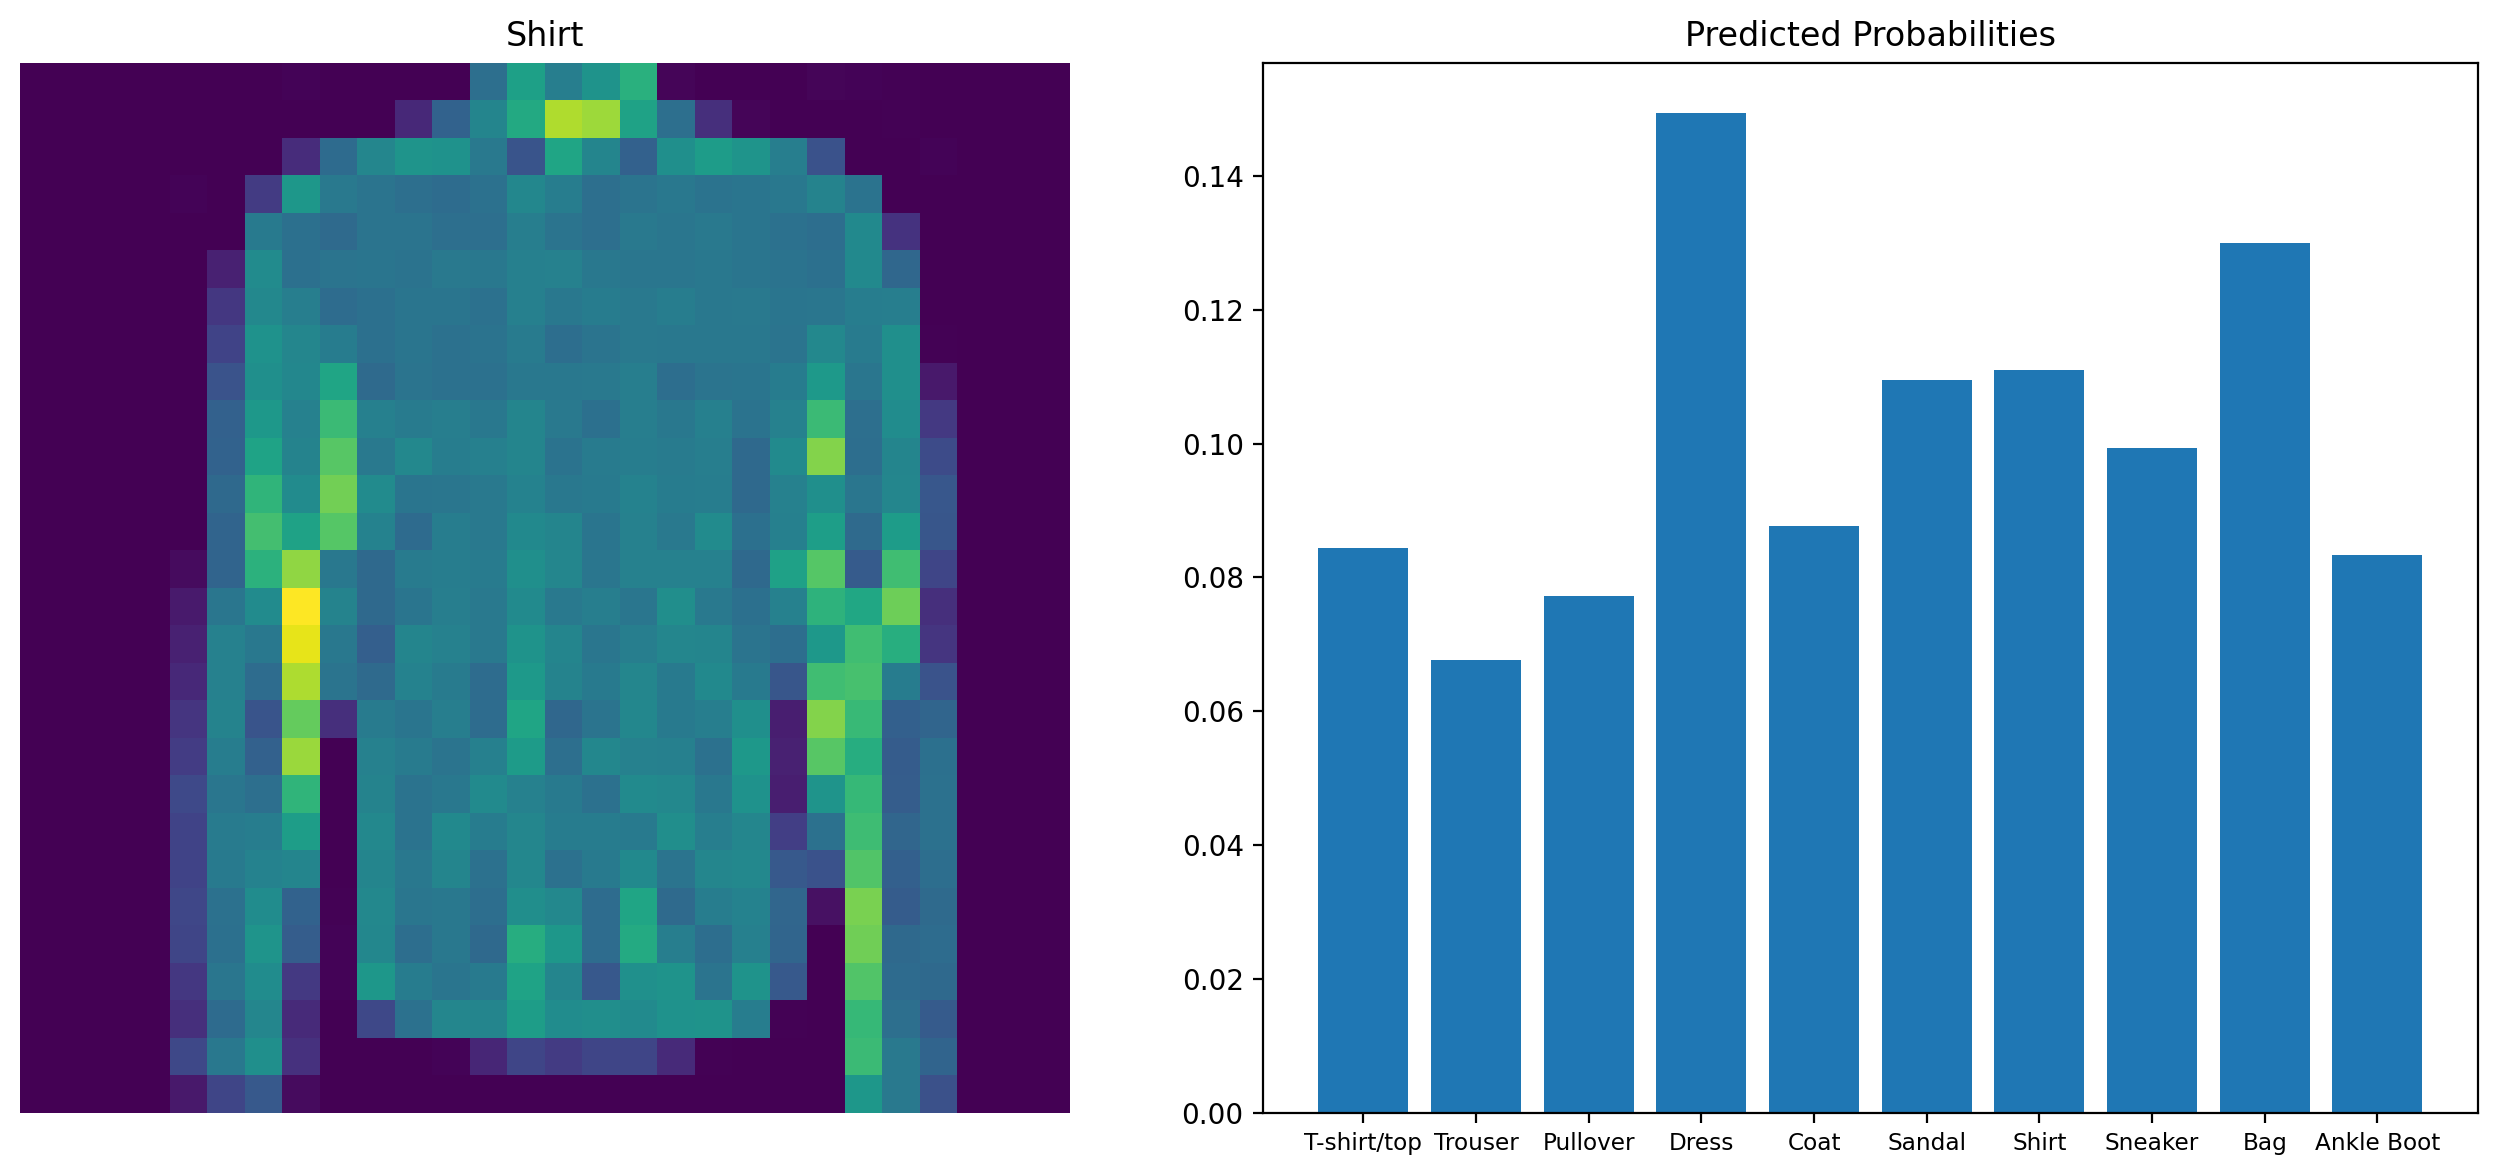

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(test_dl)
for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
        img, label = images[49], labels[49]
        img = img.view(img.shape[0], -1)
    else:
        print("Dataset size is too small to access index 49.")
images, labels = images.to(device), labels.to(device)
index = 49
img, label = images[index], labels[index]
img = img.view(img.shape[0], -1)
proba = torch.exp(model(img))

desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(images[index].cpu().numpy().squeeze())
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

## Validate on test set

In [10]:

with torch.no_grad():
    batch_acc = []
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        proba = torch.exp(model(images))
        _, pred_labels = proba.topk(1, dim=1)
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Test Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Test Accuracy: 27.43%
